In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from gplearn.genetic import SymbolicRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
trn = xr.open_dataset('foo/lores.nc')
tst = xr.open_dataset('bar/lores.nc')

In [142]:
xfer = xr.open_dataset('baz/lores.nc')

# Create a library of basis functions which are derivatives of various quantites

In [144]:
for ds in [trn, tst, xfer]:
    ds['u_x'] = ds.u.differentiate('x')
    ds['u_y'] = ds.u.differentiate('y')
    ds['v_x'] = ds.v.differentiate('x')
    ds['v_y'] = ds.v.differentiate('y')
    
    ds['u_xx'] = ds.u_x.differentiate('x')
    ds['u_xy'] = ds.u_x.differentiate('y')
    ds['u_yy'] = ds.u_y.differentiate('y')
    ds['v_xx'] = ds.v_x.differentiate('x')
    ds['v_xy'] = ds.v_x.differentiate('y')
    ds['v_yy'] = ds.v_y.differentiate('y')
    
    ds['q_x'] = ds.q.differentiate('x')
    ds['q_y'] = ds.q.differentiate('y')

    ds['q_xx'] = ds.q_x.differentiate('x')
    ds['q_yy'] = ds.q_y.differentiate('y')
    ds['q_xy'] = ds.q_x.differentiate('y')

    ds['dqdt_x'] = ds.dqdt.differentiate('x')
    ds['dqdt_y'] = ds.dqdt.differentiate('y')

# Goal will be to predict our two versions of subgrid forcing in the upper layer based on our features in both layers

In [5]:
Y1 = trn.isel(lev=0).q_forcing_advection.data.ravel()
Y1_sd = np.std(Y1)
Y1 = Y1 / Y1_sd

Y2 = trn.isel(lev=0).q_forcing_model.data.ravel()
Y2_sd = np.std(Y2)
Y2 = Y2 / Y2_sd

In [68]:
feats = ['q','q_x','q_y','q_xx','q_xy','q_yy','dqdt','dqdt_x','dqdt_y','u','v','u_x','u_y','v_x','v_y',
        'u_xx','u_xy','u_yy','v_xx','v_xy','v_yy']
feature_names = [f+'1'for f in feats]+[f+'2'for f in feats]

X = np.array([
    trn.isel(lev=0)[feat].data.ravel()
    for feat in feats
] + [
    trn.isel(lev=1)[feat].data.ravel()
    for feat in feats
]).T

X_scale = StandardScaler()
X = X_scale.fit_transform(X)

X.shape

(356352, 42)

In [70]:
Y1_test = tst.isel(lev=0).q_forcing_advection.data.ravel()
Y1_test = Y1_test / Y1_sd

Y2_test = tst.isel(lev=0).q_forcing_model.data.ravel()
Y2_test = Y2 / Y2_sd

X_test = np.array([
    tst.isel(lev=0)[feat].data.ravel()
    for feat in feats
] + [
    tst.isel(lev=1)[feat].data.ravel()
    for feat in feats
]).T

X_test = X_scale.fit_transform(X_test)

X_test.shape

(356352, 42)

In [145]:
Y1_xfer = xfer.isel(lev=0).q_forcing_advection.data.ravel()
Y1_xfer = Y1_xfer / Y1_sd

Y2_xfer = xfer.isel(lev=0).q_forcing_model.data.ravel()
Y2_xfer = Y2 / Y2_sd

X_xfer = np.array([
    xfer.isel(lev=0)[feat].data.ravel()
    for feat in feats
] + [
    xfer.isel(lev=1)[feat].data.ravel()
    for feat in feats
]).T

X_xfer = X_scale.fit_transform(X_xfer)

X_xfer.shape

(356352, 42)

# Run linear regression and Lasso baselines (not combining any symbols)

In [146]:
lr1 = LinearRegression()
lr1.fit(X, Y1)
lr1.score(X, Y1), lr1.score(X_test, Y1_test), lr1.score(X_xfer, Y1_xfer)

(0.6177161595976289, 0.6223287274649336, 0.329920907336929)

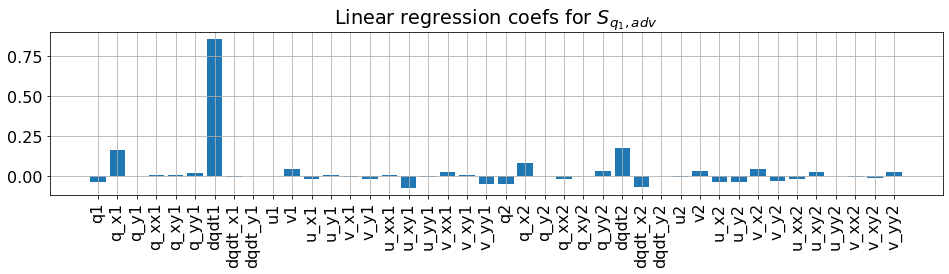

In [75]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), lr1.coef_)
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("Linear regression coefs for $S_{q_1,adv}$")
plt.show()

In [147]:
lr2 = LinearRegression()
lr2.fit(X, Y2)
lr2.score(X, Y2), lr2.score(X_test, Y2_test), lr2.score(X_xfer, Y2_xfer)

(0.040615742338866445, -4.440892098500626e-16, -4.440892098500626e-16)

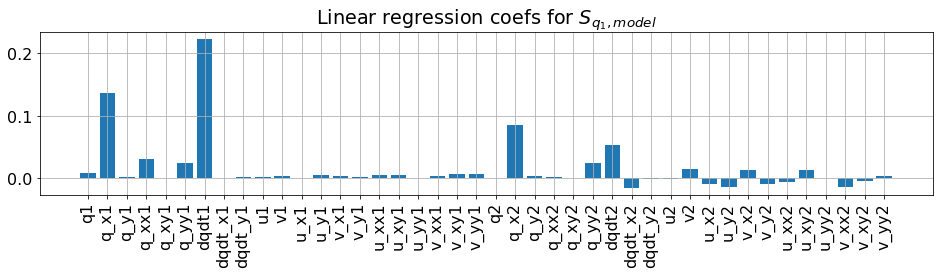

In [77]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), lr2.coef_)
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("Linear regression coefs for $S_{q_1,model}$")
plt.show()

In [148]:
ted1 = Lasso(alpha=0.05)
ted1.fit(X, Y1)
ted1.score(X, Y1), ted1.score(X_test, Y1_test), ted1.score(X_xfer, Y1_xfer)

(0.5963998889802196, 0.5989884160658678, 0.44656476954082036)

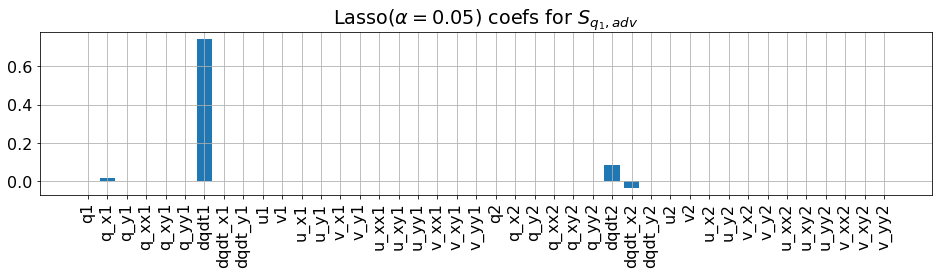

In [79]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), ted1.coef_)
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("Lasso($\\alpha=0.05$) coefs for $S_{q_1,adv}$")
plt.show()

In [149]:
ted2 = Lasso(alpha=0.05)
ted2.fit(X, Y2)
ted2.score(X, Y2), ted2.score(X_test, Y2_test), ted2.score(X_xfer, Y2_xfer)

(0.027675917656226123, -4.440892098500626e-16, -4.440892098500626e-16)

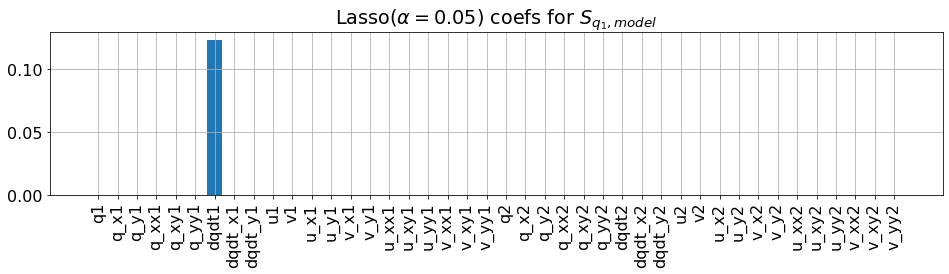

In [81]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), ted2.coef_)
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("Lasso($\\alpha=0.05$) coefs for $S_{q_1,model}$")
plt.show()

# Run neural network baseline (= as well as we can expect symbolic regression to do from the same inputs)

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('.')
from models import train

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(X.shape[1], 100)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x
    
net = Net()
train(net,X,Y1.reshape(-1,1),num_epochs=20)

Loss after Epoch 1: 0.3148662293806201
Loss after Epoch 2: 0.26112441630330174
Loss after Epoch 3: 0.25153632862720876
Loss after Epoch 4: 0.2434667299565827
Loss after Epoch 5: 0.23715670639515224
Loss after Epoch 6: 0.23192514784248738
Loss after Epoch 7: 0.22720501674058172
Loss after Epoch 8: 0.2230274071080621
Loss after Epoch 9: 0.21998488332610577
Loss after Epoch 10: 0.21719251113044546
Loss after Epoch 11: 0.19949690859106467
Loss after Epoch 12: 0.19679367419629326
Loss after Epoch 13: 0.19580391499524316
Loss after Epoch 14: 0.19502862176493924
Loss after Epoch 15: 0.19428009939066873
Loss after Epoch 16: 0.19196578319118915
Loss after Epoch 17: 0.19169179723068172
Loss after Epoch 18: 0.1913830173026567
Loss after Epoch 19: 0.19136757039446275
Loss after Epoch 20: 0.19135652968242509


In [111]:
from sklearn.metrics import r2_score

In [150]:
Y1_pred = net(torch.as_tensor(X)).detach().numpy()
Y1_pred_test = net(torch.as_tensor(X_test)).detach().numpy()
Y1_pred_xfer = net(torch.as_tensor(X_xfer)).detach().numpy()
r2_score(Y1,Y1_pred), r2_score(Y1_test,Y1_pred_test), r2_score(Y1_xfer,Y1_pred_xfer)

(0.8086841581206481, 0.7916678967243298, -0.05866849460728485)

Unsurprisingly, the NN does much better than linear regression at predicting the advection version of subgrid forcing. However, it fails to transfer to the jet configuration. Still, let's investigate what it learned.

In [85]:
import torch.autograd as autograd

X_grad = torch.as_tensor(X).requires_grad_()
Y_grad = net(X_grad)
dy_dx = autograd.grad(Y_grad.sum(), X_grad)[0].detach().numpy()

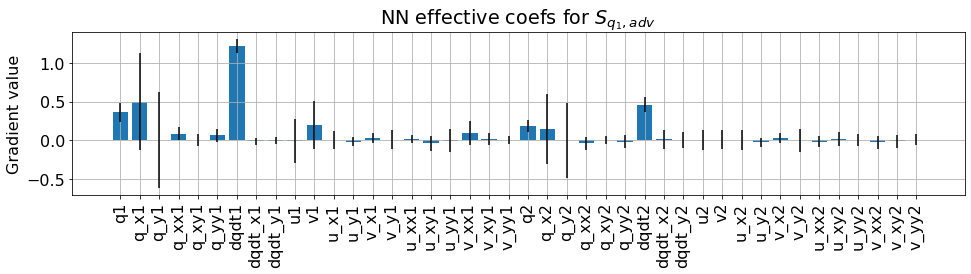

In [86]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(X.shape[1]), dy_dx.mean(axis=0), yerr=dy_dx.std(axis=0))
plt.xticks(np.arange(X.shape[1]), feature_names, rotation=90)
plt.grid()
plt.title("NN effective coefs for $S_{q_1,adv}$")
plt.ylabel("Gradient value")
plt.show()

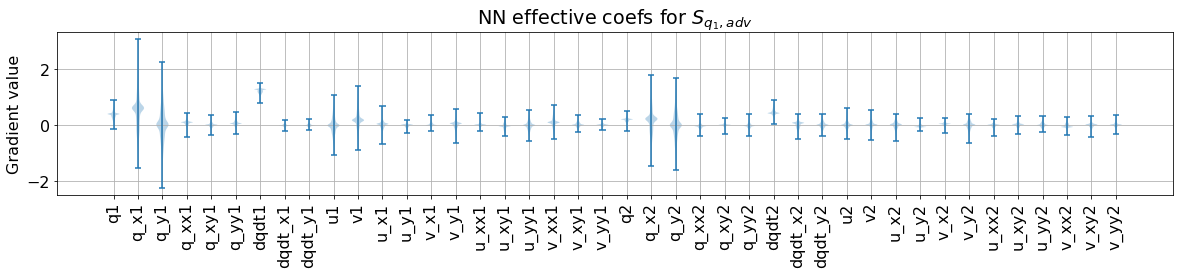

In [87]:
order = np.arange(len(dy_dx))
np.random.shuffle(order)
plt.figure(figsize=(20,3))
plt.violinplot(dy_dx[order[:10000]])
plt.grid()
plt.xticks(np.arange(X.shape[1])+1, feature_names, rotation=90)
plt.title("NN effective coefs for $S_{q_1,adv}$")
plt.ylabel("Gradient value")
plt.show()

In [100]:
important_feats = np.argwhere(np.abs(dy_dx).mean(axis=0) > 0.15)[:,0]
print("Important features:")
print([feature_names[i] for i in important_feats])

Important features:
['q1', 'q_x1', 'q_y1', 'dqdt1', 'u1', 'v1', 'q2', 'q_x2', 'q_y2', 'dqdt2']


For predicting this version of the upper layer's subgrid forcing, it looks like the relevant features are the potential vorticity plus its spatial and time derivatives at both layers, as well as the velocity in the upper layer. It might make sense to initialize symbolic regression with those terms.

But how should symbolic regression combine these terms? Let's investigate with a quick second-order test:

In [139]:
baseline = Y1_pred

dx = 0.01

perturbed_fs = {}

for f in important_feats:
    df = np.zeros_like(X)
    df[:,f] = dx
    perturbed_fs[f] = (baseline - net(torch.as_tensor(X + df)).detach().numpy())

In [140]:
doubly_perturbed_fs = {}

for f1 in important_feats:
    for f2 in important_feats:
        df12 = np.zeros_like(X)
        df12[:,f1] += dx
        df12[:,f2] += dx
        doubly_perturbed_fs[(f1,f2)] = (baseline - net(torch.as_tensor(X + df12)).detach().numpy())

In [129]:
second_diffs = np.array([[
    np.abs(doubly_perturbed_fs[(i,j)] - perturbed_fs[i] - perturbed_fs[j]).mean()
    for i in important_feats] for j in important_feats
])

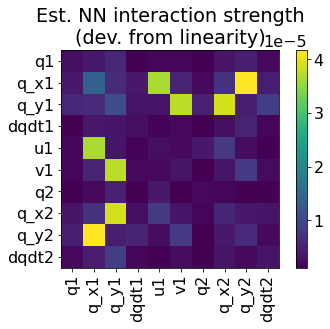

In [141]:
plt.title("Est. NN interaction strength\n(dev. from linearity)")
plt.imshow(second_diffs)
plt.yticks(range(len(important_feats)), [feature_names[i] for i in important_feats])
plt.xticks(range(len(important_feats)), [feature_names[i] for i in important_feats], rotation=90)
plt.colorbar()
plt.show()

A very rudimentary analysis of how the neural network is combining these terms suggests interactions between x/y-velocity and the x/y derivatives of $q$, as well as between the x/y-derivative of $q_1$ and the alternate y/x-derivatives of $q_2$.

Ok, now let's try to predict our alternate version of subgrid forcing.

In [88]:
net2 = Net()
train(net2,X,Y2.reshape(-1,1))

Loss after Epoch 1: 0.9389107989939465
Loss after Epoch 2: 0.9082697481131075
Loss after Epoch 3: 0.901543928535077
Loss after Epoch 4: 0.8968604827867072
Loss after Epoch 5: 0.8915195718257763
Loss after Epoch 6: 0.8870626833536074
Loss after Epoch 7: 0.8819135701465796
Loss after Epoch 8: 0.8774043913641624
Loss after Epoch 9: 0.8735672724914962
Loss after Epoch 10: 0.870541194748219
Loss after Epoch 11: 0.8674378232848455
Loss after Epoch 12: 0.8654802531999504
Loss after Epoch 13: 0.8629714575242894
Loss after Epoch 14: 0.8599630673630057
Loss after Epoch 15: 0.8580528709009804
Loss after Epoch 16: 0.856384885893471
Loss after Epoch 17: 0.8548469922703359
Loss after Epoch 18: 0.852838279296719
Loss after Epoch 19: 0.8520395669754295
Loss after Epoch 20: 0.8500002490292335
Loss after Epoch 21: 0.8487364987109456
Loss after Epoch 22: 0.8483356976046644
Loss after Epoch 23: 0.8474574724811761
Loss after Epoch 24: 0.846359096804698
Loss after Epoch 25: 0.8451176713777427
Loss after Epo

In [153]:
Y2_pred = net2(torch.as_tensor(X)).detach().numpy()
Y2_pred_test = net2(torch.as_tensor(X_test)).detach().numpy()
Y2_pred_xfer = net2(torch.as_tensor(X_xfer)).detach().numpy()
print("Train, Test, Transfer")
print(r2_score(Y2,Y2_pred), r2_score(Y2_test,Y2_pred_test), r2_score(Y2_xfer,Y2_pred_xfer))

Train, Test, Transfer
0.18953065531450086 -4.440892098500626e-16 -4.440892098500626e-16


Interestingly, it looks like we can't really predict our alternate version of subgrid forcing using this method -- performance seems ok on the training set, but it even fails on the test set, indicating overfitting / memorization (perhaps due to an inherent lack of predictiveness in the features).

# Try nearest neighbors (for Joan)

In [91]:
from sklearn.neighbors import KNeighborsRegressor

knn1 = KNeighborsRegressor(n_neighbors=1)

order = np.arange(len(X))
np.random.shuffle(order)
knn1.fit(X[order[:50000]],Y1[order[:50000]])
knn1.score(X[order[:50000]],Y1[order[:50000]])

1.0

In [92]:
knn1.score(X_test[order[:50000]],Y1_test[order[:50000]])

0.08768421474522015

In [94]:
knn2 = KNeighborsRegressor(n_neighbors=1)
knn2.fit(X[order[:50000]],Y2[order[:50000]])
knn2.score(X[order[:50000]],Y2[order[:50000]])

1.0

In [95]:
knn2.score(X_test[order[:50000]],Y2_test[order[:50000]])

-9.724253445586584e-06

Nearest neighbors does not work well on the test set :(

# Try symbolic regression with genetic programming to combine terms

In [101]:
reg = SymbolicRegressor(feature_names=feature_names,
                        population_size=5000,
                        generations=20, stopping_criteria=0.01,
                        p_crossover=0.7, p_subtree_mutation=0.1,
                        p_hoist_mutation=0.05, p_point_mutation=0.1,
                        max_samples=0.9, verbose=1,
                        parsimony_coefficient=0.01, random_state=0)
reg.fit(X,Y1)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/opt/miniconda3/lib/python3.9/site-packages/gplearn/functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    25.75           384222        3         0.590163         0.591998     20.44m
   1     3.42          869.455        3         0.372905         0.374827     13.44m
   2     3.19          4.10542        3          0.37274         0.376306     13.02m
   3     1.61          2.04752        3         0.372386         0.379495     11.59m
   4     2.43          2.00931        3         0.371995         0.383019     12.39m
   5     3.26          4.38418        3         0.372069         0.382352     12.76m
   6     3.18          1.59018        3         0.372006         0.382913     11.91m
   7     3.25          212.964        3         0.371991         0.383047     11.00m
   8     3.23          3.72685        3          0.37214         0.381715     10.08m
   9     3.23          3.34588        3         0.371786         0.384895      9.21m
  10     3.19          2.89646        3         0.372002         0.382952      8.32m
  11     3.23          39.6525        3         0.372099         

SymbolicRegressor(feature_names=['q1', 'q_x1', 'q_y1', 'q_xx1', 'q_xy1',
                                 'q_yy1', 'dqdt1', 'dqdt_x1', 'dqdt_y1', 'u1',
                                 'v1', 'u_x1', 'u_y1', 'v_x1', 'v_y1', 'u_xx1',
                                 'u_xy1', 'u_yy1', 'v_xx1', 'v_xy1', 'v_yy1',
                                 'q2', 'q_x2', 'q_y2', 'q_xx2', 'q_xy2',
                                 'q_yy2', 'dqdt2', 'dqdt_x2', 'dqdt_y2', ...],
                  max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [102]:
print(reg._program)

mul(0.798, dqdt1)


In [116]:
Y_gp = reg.predict(X)
Y_gp2 = reg.predict(X_test)
r2_score(Y_gp,Y1), r2_score(Y_gp2, Y1_test)

(0.32639415104597413, 0.30907511022094303)